In [331]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
import time
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from random import sample
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
%matplotlib inline

In [420]:
def split_data(df, train_percentage):
    df.fillna(0, inplace = True)
    row_num = df.shape[0]
    split_num = round(row_num * train_percentage)
    random = sample(range(row_num), k=len(range(row_num)))
    df_train = df.iloc[random[0:split_num]]
    df_test = df.iloc[random[split_num:]]
    return df_train, df_test
# A better option:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [393]:
def remove_rare_feature (df, n):
    n_sample = df.shape[0]
    df_sub = pd.DataFrame()
    feature_occurence = df.sum(axis =0)
    print('features selected are:')
    for index, value in df.sum(axis = 0).iteritems():
        if value >= n and value <= (n_sample - n): 
            df_sub[index] = df[index]
            print(index, value)
    return df_sub

# Read in file and remove rare features

In [394]:
data_csv_name = 'df_cough_2014.csv_convertNA.csv_convertRD_DIAG1R.csv_transformed.csv'
df = pd.read_csv(data_csv_name)
n = 20
print('The size of data:',df.shape)
df = remove_rare_feature (df, n)
print('The size of data after removing rare features:', df.shape)
#df_train, df_test = split_data(df, 0.8)

The size of data: (956, 210)
features selected are:
DIAG1R 218.0
AGE 303.358695652
HTIN 674.827586207
WTLB 324.441520468
BMI 262.158725829
TEMPF 565.549180328
BPSYS 407.0
BPDIAS 380.846153846
SEX_2 458.0
RACERETH_2 76.0
RACERETH_3 128.0
RACERETH_4 76.0
USETOBAC_2.0 96.0
USETOBAC_3.0 59.0
MAJOR_2 62.0
MAJOR_3 68.0
MAJOR_9 26.0
HYPLIPID_1 114.0
OBESITY_1 43.0
DIABTYP 59.0
R_10050.0 24.0
R_10100.0 179.0
R_10150.0 35.0
R_10502.0 20.0
R_10900.0 20.0
R_12100.0 70.0
R_13551.0 40.0
R_14100.0 26.0
R_14101.0 44.0
R_14150.0 54.0
R_14250.0 82.0
R_14350.0 20.0
R_14551.0 173.0
R_14750.0 40.0
R_15300.0 34.0
DEPR 71.0
R_nasal_congestion 399.0
The size of data after removing rare features: (956, 37)


## Read in splitted data (for reproducibility)

In [332]:
#df_train.to_csv('df_train.csv')
#df_test.to_csv('df_test.csv')
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

## Split x and y, and reduce two more features

In [387]:
X_train_initial = df_train.drop(['DIAG1R', 'HTIN', 'R_14100.0'], axis=1).values # some features: .iloc[:,0:n]
y_train = df_train.DIAG1R.values
X_test_initial = df_test.drop(['DIAG1R', 'HTIN', 'R_14100.0'], axis=1).values
y_test = df_test.DIAG1R.values
features = df_train.drop(['DIAG1R', 'HTIN', 'R_14100.0'], axis=1).columns # some features: [0:339]

print('the stats of training samples are:\n', df_train.DIAG1R.value_counts())
print('the stats of testing samples are:\n', df_test.DIAG1R.value_counts())

the stats of training samples are:
 0    593
1    172
Name: DIAG1R, dtype: int64
the stats of testing samples are:
 0    145
1     46
Name: DIAG1R, dtype: int64


# EDA: PCA
## Variance explained by principle components

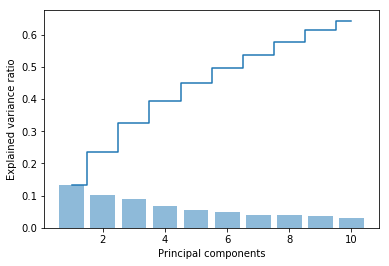

In [356]:
def PCA_explained (X, n_components):
    from sklearn.decomposition import PCA
    pca = PCA(n_components= n_components)
    X_pca = pca.fit_transform(X)
    plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
    plt.step(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.show()
PCA_explained (X_train_initial, 10)

In [384]:
def PCA_n (X, y, n_components):
    pca = PCA(n_components = n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

def plot_PCA (X_pca, y, PC_x, PC_y):
    plt.scatter(X_pca[y == 0][:, PC_x], X_pca[y == 0][:, PC_y], color = 'blue', alpha = .8, s = 2)
    plt.scatter(X_pca[y == 1][:, PC_x], X_pca[y == 1][:, PC_y], color='red', alpha = .8, s = 2)
    plt.xlabel('PC' + str(PC_x + 1))
    plt.ylabel('PC' + str(PC_y + 1))
    plt.legend(['Mild','Severe'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()

## PCA 2D plot

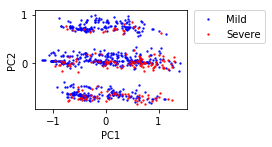

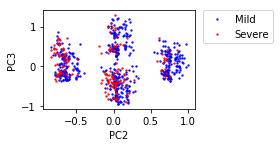

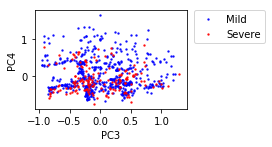

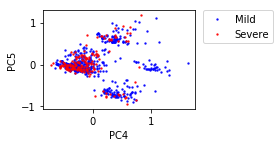

In [386]:
pca, X_pca = PCA_n (X_train_initial, y_train, 10)

plt.subplot(221);
plot_PCA (X_pca, y_train, 0, 1)
plt.subplot(222);
plot_PCA (X_pca, y_train, 1, 2)
plt.subplot(223);
plot_PCA (X_pca, y_train, 2, 3)
plt.subplot(224);
plot_PCA (X_pca, y_train, 3, 4)

## PCA eigenvectors 

In [388]:
np.set_printoptions(suppress=True)
print(features)
print(pca.components_)

Index(['AGE', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'SEX_2', 'RACERETH_2',
       'RACERETH_3', 'RACERETH_4', 'USETOBAC_2.0', 'USETOBAC_3.0', 'MAJOR_2',
       'MAJOR_3', 'MAJOR_9', 'HYPLIPID_1', 'OBESITY_1', 'DIABTYP', 'R_10050.0',
       'R_10100.0', 'R_10150.0', 'R_10502.0', 'R_10900.0', 'R_12100.0',
       'R_13551.0', 'R_14101.0', 'R_14150.0', 'R_14250.0', 'R_14350.0',
       'R_14551.0', 'R_14750.0', 'R_15300.0', 'DEPR', 'R_nasal_congestion'],
      dtype='object')
[[ 0.408  0.275  0.22  -0.121  0.332  0.279 -0.353  0.002 -0.168  0.006
   0.222  0.103  0.089  0.083  0.001  0.261  0.113  0.134  0.034 -0.208
   0.002  0.014  0.004  0.037  0.012  0.034  0.095  0.028 -0.003 -0.056
   0.033 -0.025  0.126 -0.32 ]
 [-0.012 -0.001  0.012  0.055 -0.001  0.021 -0.698 -0.019  0.029  0.03
  -0.027  0.033 -0.078  0.005 -0.001 -0.024  0.023 -0.019  0.004  0.026
   0.003  0.003  0.001  0.085  0.049  0.056 -0.04  -0.065  0.004  0.142
  -0.018 -0.059  0.042  0.673]
 [ 0.199  0.215  0.132 -0.

# Training: Logistic regression
## Initial fitting

In [133]:
features = df_train.drop(['DIAG1R', 'HTIN', 'R_14100.0'], axis=1).columns # some features: [0:339]

#features = ['MAJOR_3', 'R_14150.0', 'R_14250.0'] #chosen from RFECV
#X_train_initial = df_train[['MAJOR_3', 'R_14150.0', 'R_14250.0']].values #chosen from RFECV, but actually lower recall on CV.
#X_test_initial = df_test[['MAJOR_3', 'R_14150.0', 'R_14250.0']].values

logregcv = LogisticRegressionCV(scoring='recall', class_weight='balanced')
est_initial = RFE(logregcv, n_features_to_select=10, step = 1)
est_initial.fit(X_train_initial, y_train)

RFE(estimator=LogisticRegressionCV(Cs=10, class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='recall', solver='lbfgs', tol=0.0001,
           verbose=0),
  n_features_to_select=10, step=1, verbose=0)

## Best hyperparameter

In [134]:
best_C = est_initial.estimator_.C_[0] # If C is small, lambda is large, a lot of regularization.
print(best_C)

0.35938136638


## Choose the best number of features

Optimal number of features : 3


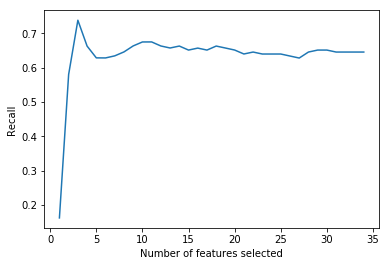

Index(['AGE', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'SEX_2', 'RACERETH_2',
       'RACERETH_3', 'RACERETH_4', 'USETOBAC_2.0', 'USETOBAC_3.0', 'MAJOR_2',
       'MAJOR_3', 'MAJOR_9', 'HYPLIPID_1', 'OBESITY_1', 'DIABTYP', 'R_10050.0',
       'R_10100.0', 'R_10150.0', 'R_10502.0', 'R_10900.0', 'R_12100.0',
       'R_13551.0', 'R_14101.0', 'R_14150.0', 'R_14250.0', 'R_14350.0',
       'R_14551.0', 'R_14750.0', 'R_15300.0', 'DEPR', 'R_nasal_congestion'],
      dtype='object')
[False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False  True  True False False False False False False]
[ 2 21 16 24 15 29 26 10  9 28 14  4  3  1 18 25 23 19 30 22 31 13  6 12 20
 11  1  1 17  7 27  5 32  8]
Index(['MAJOR_3', 'R_14150.0', 'R_14250.0'], dtype='object')


In [353]:
def best_RFE(X_train_initial, y_train, features):
    from sklearn.feature_selection import RFECV
    logregcv = LogisticRegressionCV(scoring='recall', class_weight='balanced')
    rfecv = RFECV(logregcv, step=1, scoring='recall')
    rfecv.fit(X_train_initial, y_train)
    print("Optimal number of features : %d" % rfecv.n_features_)
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Recall")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    print(features)
    
    # QC
    print(rfecv.support_)
    print(rfecv.ranking_)
    print(features[np.where(rfecv.ranking_==1)])

best_RFE(X_train_initial, y_train, features)

In [397]:
print('Features used are:', features)
features_selected = features[np.where(est_initial.ranking_ ==1)]
print('10 features selected are:',features_selected)

Features used are: Index(['AGE', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'SEX_2', 'RACERETH_2',
       'RACERETH_3', 'RACERETH_4', 'USETOBAC_2.0', 'USETOBAC_3.0', 'MAJOR_2',
       'MAJOR_3', 'MAJOR_9', 'HYPLIPID_1', 'OBESITY_1', 'DIABTYP', 'R_10050.0',
       'R_10100.0', 'R_10150.0', 'R_10502.0', 'R_10900.0', 'R_12100.0',
       'R_13551.0', 'R_14101.0', 'R_14150.0', 'R_14250.0', 'R_14350.0',
       'R_14551.0', 'R_14750.0', 'R_15300.0', 'DEPR', 'R_nasal_congestion'],
      dtype='object')
10 features selected are: Index(['AGE', 'USETOBAC_3.0', 'MAJOR_2', 'MAJOR_3', 'R_10900.0', 'R_14150.0',
       'R_14250.0', 'R_14551.0', 'R_15300.0', 'R_nasal_congestion'],
      dtype='object')


## Initial model performance

In [135]:
print("Grid scores on development set:")
print()
means = np.mean(est_initial.estimator_.scores_[1], axis=0)
stds = np.std(est_initial.estimator_.scores_[1], axis=0)
params = est_initial.estimator_.Cs_
for mean, std, param in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, param))

Grid scores on development set:

0.620 (+/-0.840) for 0.0001
0.652 (+/-0.274) for 0.00077426368268112698
0.657 (+/-0.128) for 0.0059948425031894088
0.663 (+/-0.086) for 0.046415888336127774
0.680 (+/-0.031) for 0.35938136638046259
0.669 (+/-0.044) for 2.7825594022071258
0.669 (+/-0.044) for 21.544346900318821
0.669 (+/-0.044) for 166.81005372000558
0.669 (+/-0.044) for 1291.5496650148827
0.669 (+/-0.044) for 10000.0


In [138]:
print('training set performance:\n',metrics.classification_report(y_train, est_initial.predict(X_train_initial)))
print('testing set performance:\n',metrics.classification_report(y_test, est_initial.predict(X_test_initial)))
print('TN, FP, FN, TP are:\n',metrics.confusion_matrix(y_test, est_initial.predict(X_test_initial)))

training set performance:
              precision    recall  f1-score   support

          0       0.89      0.79      0.84       593
          1       0.48      0.68      0.57       172

avg / total       0.80      0.76      0.78       765

testing set performance:
              precision    recall  f1-score   support

          0       0.89      0.81      0.85       145
          1       0.53      0.70      0.60        46

avg / total       0.81      0.78      0.79       191

TN, FP, FN, TP are:
 [[117  28]
 [ 14  32]]


## Refit with best parameters

In [139]:
X_train = df_train[features_selected].values
logreg = LogisticRegression(class_weight='balanced', C = best_C)
logreg.fit(X_train,y_train)
X_test = df_test[features_selected].values
y_predict = logreg.predict(X_test)
probas_ = logreg.predict_proba(X_test)
print('TN, FP, FN, TP are:\n',metrics.confusion_matrix(y_test, y_predict))
print()
print("Detailed classification report:")
print(metrics.classification_report(y_test, y_predict))

TN, FP, FN, TP are:
 [[117  28]
 [ 14  32]]

Detailed classification report:
             precision    recall  f1-score   support

          0       0.89      0.81      0.85       145
          1       0.53      0.70      0.60        46

avg / total       0.81      0.78      0.79       191



## Plot coefficients

In [409]:
def horizontal_bar_plot (objects, numbers, xlabel):
    fig, ax = plt.subplots(figsize = (11,6), dpi = 600)
    y_pos = np.arange(len(objects))
    ax.barh(y_pos, numbers, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(objects, fontsize = 15)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(xlabel, fontsize = 15)
    #ax.set_title('Coefficients of features', fontsize = 20)
    fig.savefig(xlabel + '_of_features.png',bbox_inches='tight');

Index(['AGE', 'USETOBAC_3.0', 'MAJOR_2', 'MAJOR_3', 'R_10900.0', 'R_14150.0',
       'R_14250.0', 'R_14551.0', 'R_15300.0', 'R_nasal_congestion'],
      dtype='object')
[[ 0.785  0.704  0.876  1.098  0.838  0.857  1.315 -0.638  1.41  -0.576]]
       coef                feature_name               label
0  0.784766                         Age                 AGE
1  0.703903                     Smoking        USETOBAC_3.0
2  0.876153   Chronic problem (routine)             MAJOR_2
3  1.097763  Chronic problem (flare-up)             MAJOR_3
4  0.838170           Allergic reaction           R_10900.0
5  0.856552         Shortness of breath           R_14150.0
6  1.315123                    Wheezing           R_14250.0
7 -0.637835                 Sore throat           R_14551.0
8  1.409888                    Vomiting           R_15300.0
9 -0.576146            Nasal congestion  R_nasal_congestion


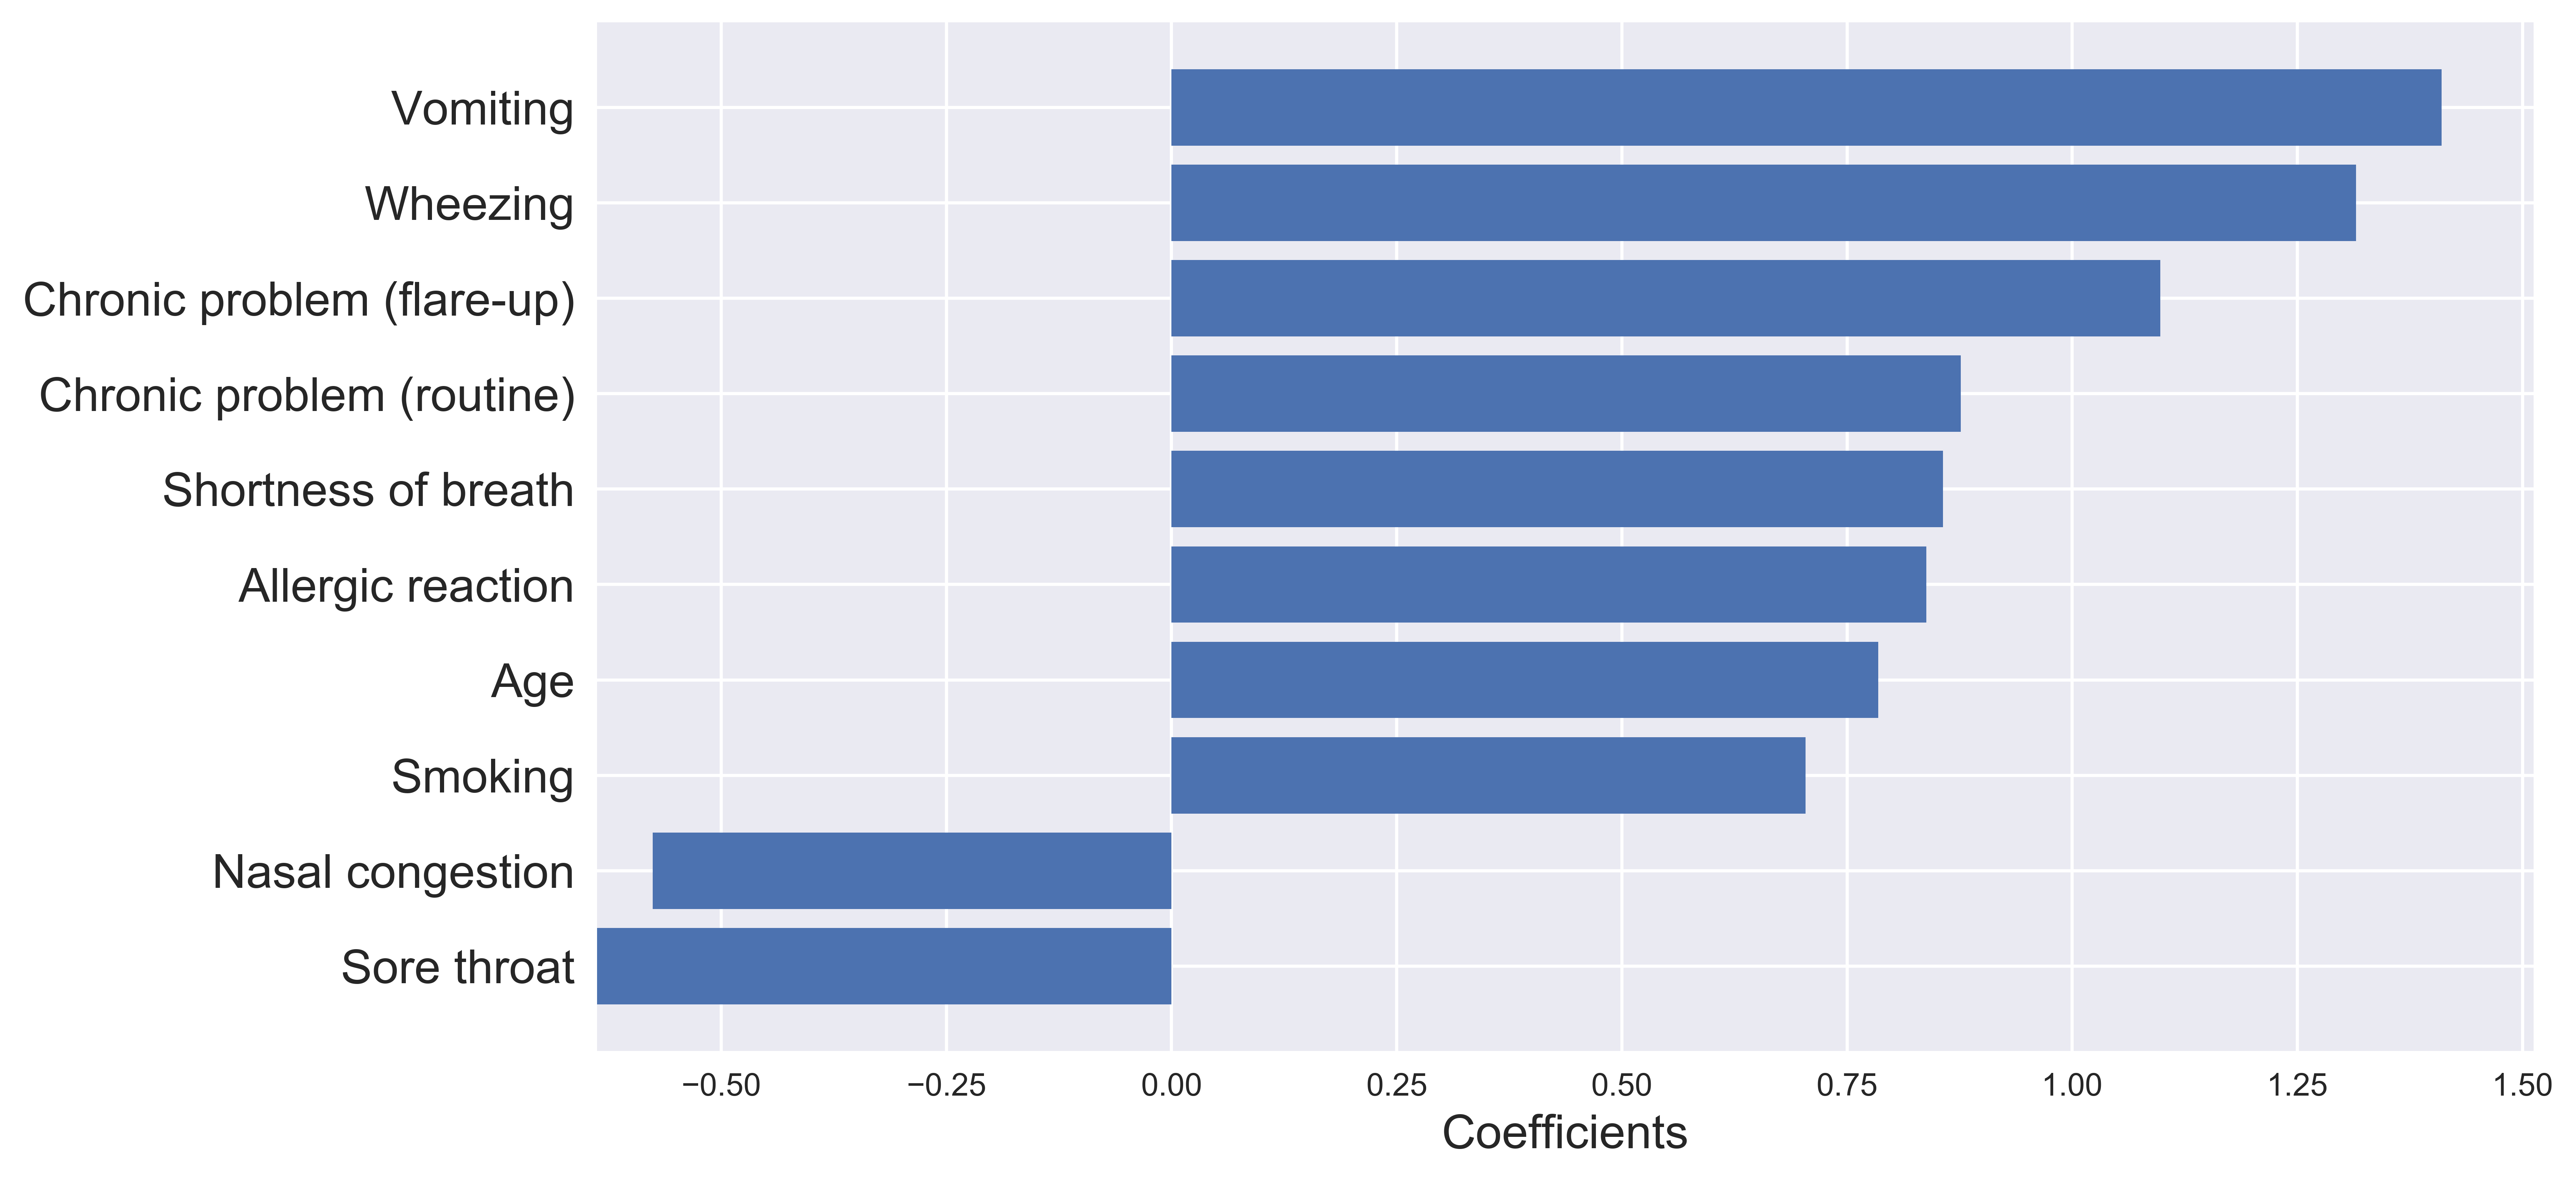

In [411]:
print(features_selected)
print(logreg.coef_)
feature_name = ['Age', 'Smoking', 'Chronic problem (routine)', 'Chronic problem (flare-up)', 'Allergic reaction',
               'Shortness of breath', 'Wheezing', 'Sore throat', 'Vomiting', 'Nasal congestion']
df_coef = pd.DataFrame({'label':features_selected,'feature_name':feature_name,'coef':logreg.coef_.flatten()})
df_coef_sorted = df_coef.sort_values(by = 'coef',axis = 0, ascending = False)
print(df_coef)
#print(np.std(X_train, 0)*est.coef_)
horizontal_bar_plot (df_coef_sorted.feature_name, df_coef_sorted.coef, 'Coefficients')

# Check feature correlations before and after selection

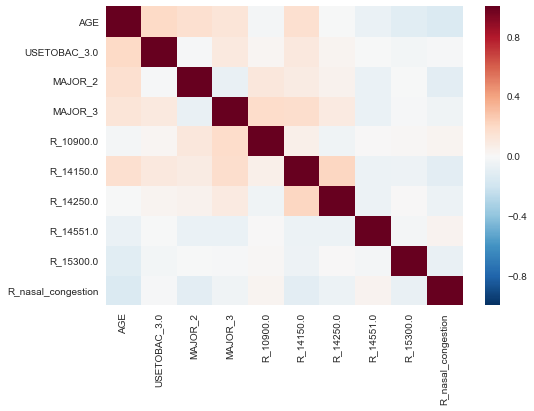

In [395]:
import seaborn
#seaborn.set_style("whitegrid", {'axes.grid' : False})
seaborn.heatmap(df[features_selected].corr())

['AGE', 'USETOBAC_3.0', 'MAJOR_2', 'MAJOR_3', 'R_10900.0', 'R_14150.0', 'R_14250.0', 'R_14551.0', 'R_15300.0', 'R_nasal_congestion']


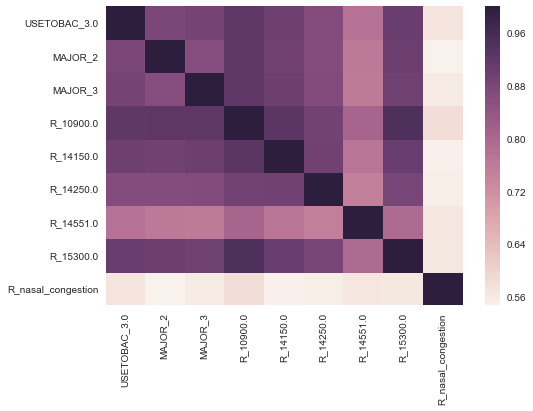

In [402]:
binary_features = list(features_selected)
print(binary_features)
binary_features.remove('AGE')
result = df[binary_features].apply(lambda col1: df[binary_features].apply(
    lambda col2: metrics.jaccard_similarity_score(col1, col2, normalize = True)))
#https://stackoverflow.com/questions/29723560/distance-matrix-for-rows-in-pandas-dataframe
seaborn.heatmap(result)

## Save and reload LR model

In [221]:
#filenameLR = 'finalized_LR_model.sav'
#pickle.dump(logreg, open(filenameLR, 'wb'))

In [228]:
features_selected = ['AGE', 'USETOBAC_3.0', 'MAJOR_2', 'MAJOR_3', 'R_10900.0', 'R_14150.0',
       'R_14250.0', 'R_14551.0', 'R_15300.0', 'R_nasal_congestion']
X_test = df_test[features_selected].values
filenameLR = 'finalized_LR_model.sav'
#load the model from disk
est_loaded = pickle.load(open(filenameLR, 'rb'))
y_predict_reloadedLR = est_loaded.predict(X_test)
print('TN, FP, FN, TP of reloaded model are:\n',metrics.confusion_matrix(y_test, y_predict_reloadedLR))
print()
print("Detailed classification report of reloaded model is:")
print(metrics.classification_report(y_test, y_predict_reloadedLR))
print('accuracy of model is: {:.2f} (same as total recall)'.format(est_loaded.score(X_test, y_test)))

TN, FP, FN, TP of reloaded model are:
 [[117  28]
 [ 14  32]]

Detailed classification report of reloaded model is:
             precision    recall  f1-score   support

          0       0.89      0.81      0.85       145
          1       0.53      0.70      0.60        46

avg / total       0.81      0.78      0.79       191

accuracy of model is: 0.78 (same as total recall)


# Training: random forests
## Initial fitting

In [117]:
param_grid = [
        {'estimator__n_estimators': list(range(10, 46, 5)),
        'estimator__max_depth': list(range(2,6,1))}
    ]

estRF_initial = RandomForestClassifier(class_weight = 'balanced')
selector = RFE(estRF_initial, n_features_to_select=10, step = 1)
clfRF_initial = model_selection.GridSearchCV(selector, param_grid=param_grid, scoring='recall', n_jobs=1, error_score=0, cv = 3) # scoring = 'f1_micro' for multiclass
clfRF_initial.fit(X_train_initial, y_train)

GridSearchCV(cv=3, error_score=0,
       estimator=RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=10, step=1, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'estimator__n_estimators': [10, 15, 20, 25, 30, 35, 40, 45], 'estimator__max_depth': [2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=0)

## Best hyperparameters

In [354]:
n_trees = clfRF_initial.best_params_['estimator__n_estimators']
n_depth = clfRF_initial.best_params_['estimator__max_depth']

print('Best parameters set found on development set: number of trees is {}, max depth is {}'.format(n_trees, n_depth))

Best parameters set found on development set: number of trees is 45, max depth is 2


## Initial model performance

In [119]:
print("Grid scores on development set:")
print()
means = clfRF_initial.cv_results_['mean_test_score']
stds = clfRF_initial.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clfRF_initial.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Features used are:', features)
features_selected2 = features[np.where(clfRF_initial.best_estimator_.ranking_ ==1)]
print('10 features selected are:', features_selected2)
print('training set performance:\n',metrics.classification_report(y_train, clfRF_initial.predict(X_train_initial)))
print('testing set performance:\n',metrics.classification_report(y_test, clfRF_initial.predict(X_test_initial)))
print('TN, FP, FN, TP of model are:\n',metrics.confusion_matrix(y_test, clfRF_initial.predict(X_test_initial)))

Grid scores on development set:

0.530 (+/-0.244) for {'estimator__max_depth': 2, 'estimator__n_estimators': 10}
0.547 (+/-0.173) for {'estimator__max_depth': 2, 'estimator__n_estimators': 15}
0.553 (+/-0.080) for {'estimator__max_depth': 2, 'estimator__n_estimators': 20}
0.547 (+/-0.205) for {'estimator__max_depth': 2, 'estimator__n_estimators': 25}
0.547 (+/-0.098) for {'estimator__max_depth': 2, 'estimator__n_estimators': 30}
0.547 (+/-0.123) for {'estimator__max_depth': 2, 'estimator__n_estimators': 35}
0.552 (+/-0.137) for {'estimator__max_depth': 2, 'estimator__n_estimators': 40}
0.617 (+/-0.137) for {'estimator__max_depth': 2, 'estimator__n_estimators': 45}
0.553 (+/-0.149) for {'estimator__max_depth': 3, 'estimator__n_estimators': 10}
0.530 (+/-0.221) for {'estimator__max_depth': 3, 'estimator__n_estimators': 15}
0.576 (+/-0.179) for {'estimator__max_depth': 3, 'estimator__n_estimators': 20}
0.518 (+/-0.136) for {'estimator__max_depth': 3, 'estimator__n_estimators': 25}
0.518 (

## Refit with best parameters

In [145]:
X_train2 = df_train[features_selected2].values
estRF = RandomForestClassifier(n_estimators = n_trees, max_depth = n_depth, class_weight = 'balanced')
estRF.fit(X_train2,y_train)
X_test2 = df_test[features_selected2].values
y_predict2 = estRF.predict(X_test2)
probas2_ = estRF.predict_proba(X_test2)
probas2 = probas2_[:,1]
print('TN, FP, FN, TP are:\n',metrics.confusion_matrix(y_test, y_predict2))
print()
print("Detailed classification report:")
print(metrics.classification_report(y_test, y_predict2))

TN, FP, FN, TP are:
 [[115  30]
 [ 18  28]]

Detailed classification report:
             precision    recall  f1-score   support

          0       0.86      0.79      0.83       145
          1       0.48      0.61      0.54        46

avg / total       0.77      0.75      0.76       191




## Save and reload RF model

In [225]:
#filenameRF = 'finalized_RF_model.sav'
#pickle.dump(estRF, open(filenameRF, 'wb'))

In [405]:
features_selected2 = ['AGE', 'BMI', 'BPSYS', 'BPDIAS', 'MAJOR_2', 'MAJOR_3', 'R_14150.0',
       'R_14250.0', 'R_14551.0', 'R_nasal_congestion']
X_test2 = df_test[features_selected2].values
filenameRF = 'finalized_RF_model.sav'
#load the model from disk
rf_loaded = pickle.load(open(filenameRF, 'rb'))
y_predict_reloadedRF = rf_loaded.predict(X_test2)
print('TN, FP, FN, TP of reloaded model are:\n',metrics.confusion_matrix(y_test, y_predict_reloadedRF))
print()
print("Detailed classification report of reloaded model is:")
print(metrics.classification_report(y_test, y_predict_reloadedRF))
print('Accuracy of model is: {:.2f} (same as total recall)'.format(rf_loaded.score(X_test2, y_test)))

TN, FP, FN, TP of reloaded model are:
 [[115  30]
 [ 18  28]]

Detailed classification report of reloaded model is:
             precision    recall  f1-score   support

          0       0.86      0.79      0.83       145
          1       0.48      0.61      0.54        46

avg / total       0.77      0.75      0.76       191

Accuracy of model is: 0.75 (same as total recall)


## Plot feature importance

[ 0.141  0.118  0.08   0.012  0.049  0.121  0.115  0.218  0.055  0.09 ]
[7 0 5 1 6 9 2 8 4 3]
         feature_name       imp               label
0                 AGE  0.141287                 AGE
1                 BMI  0.118143                 BMI
2               BPSYS  0.080396               BPSYS
3              BPDIAS  0.011629              BPDIAS
4             MAJOR_2  0.049185             MAJOR_2
5             MAJOR_3  0.120525             MAJOR_3
6           R_14150.0  0.115317           R_14150.0
7           R_14250.0  0.218084           R_14250.0
8           R_14551.0  0.055409           R_14551.0
9  R_nasal_congestion  0.090025  R_nasal_congestion


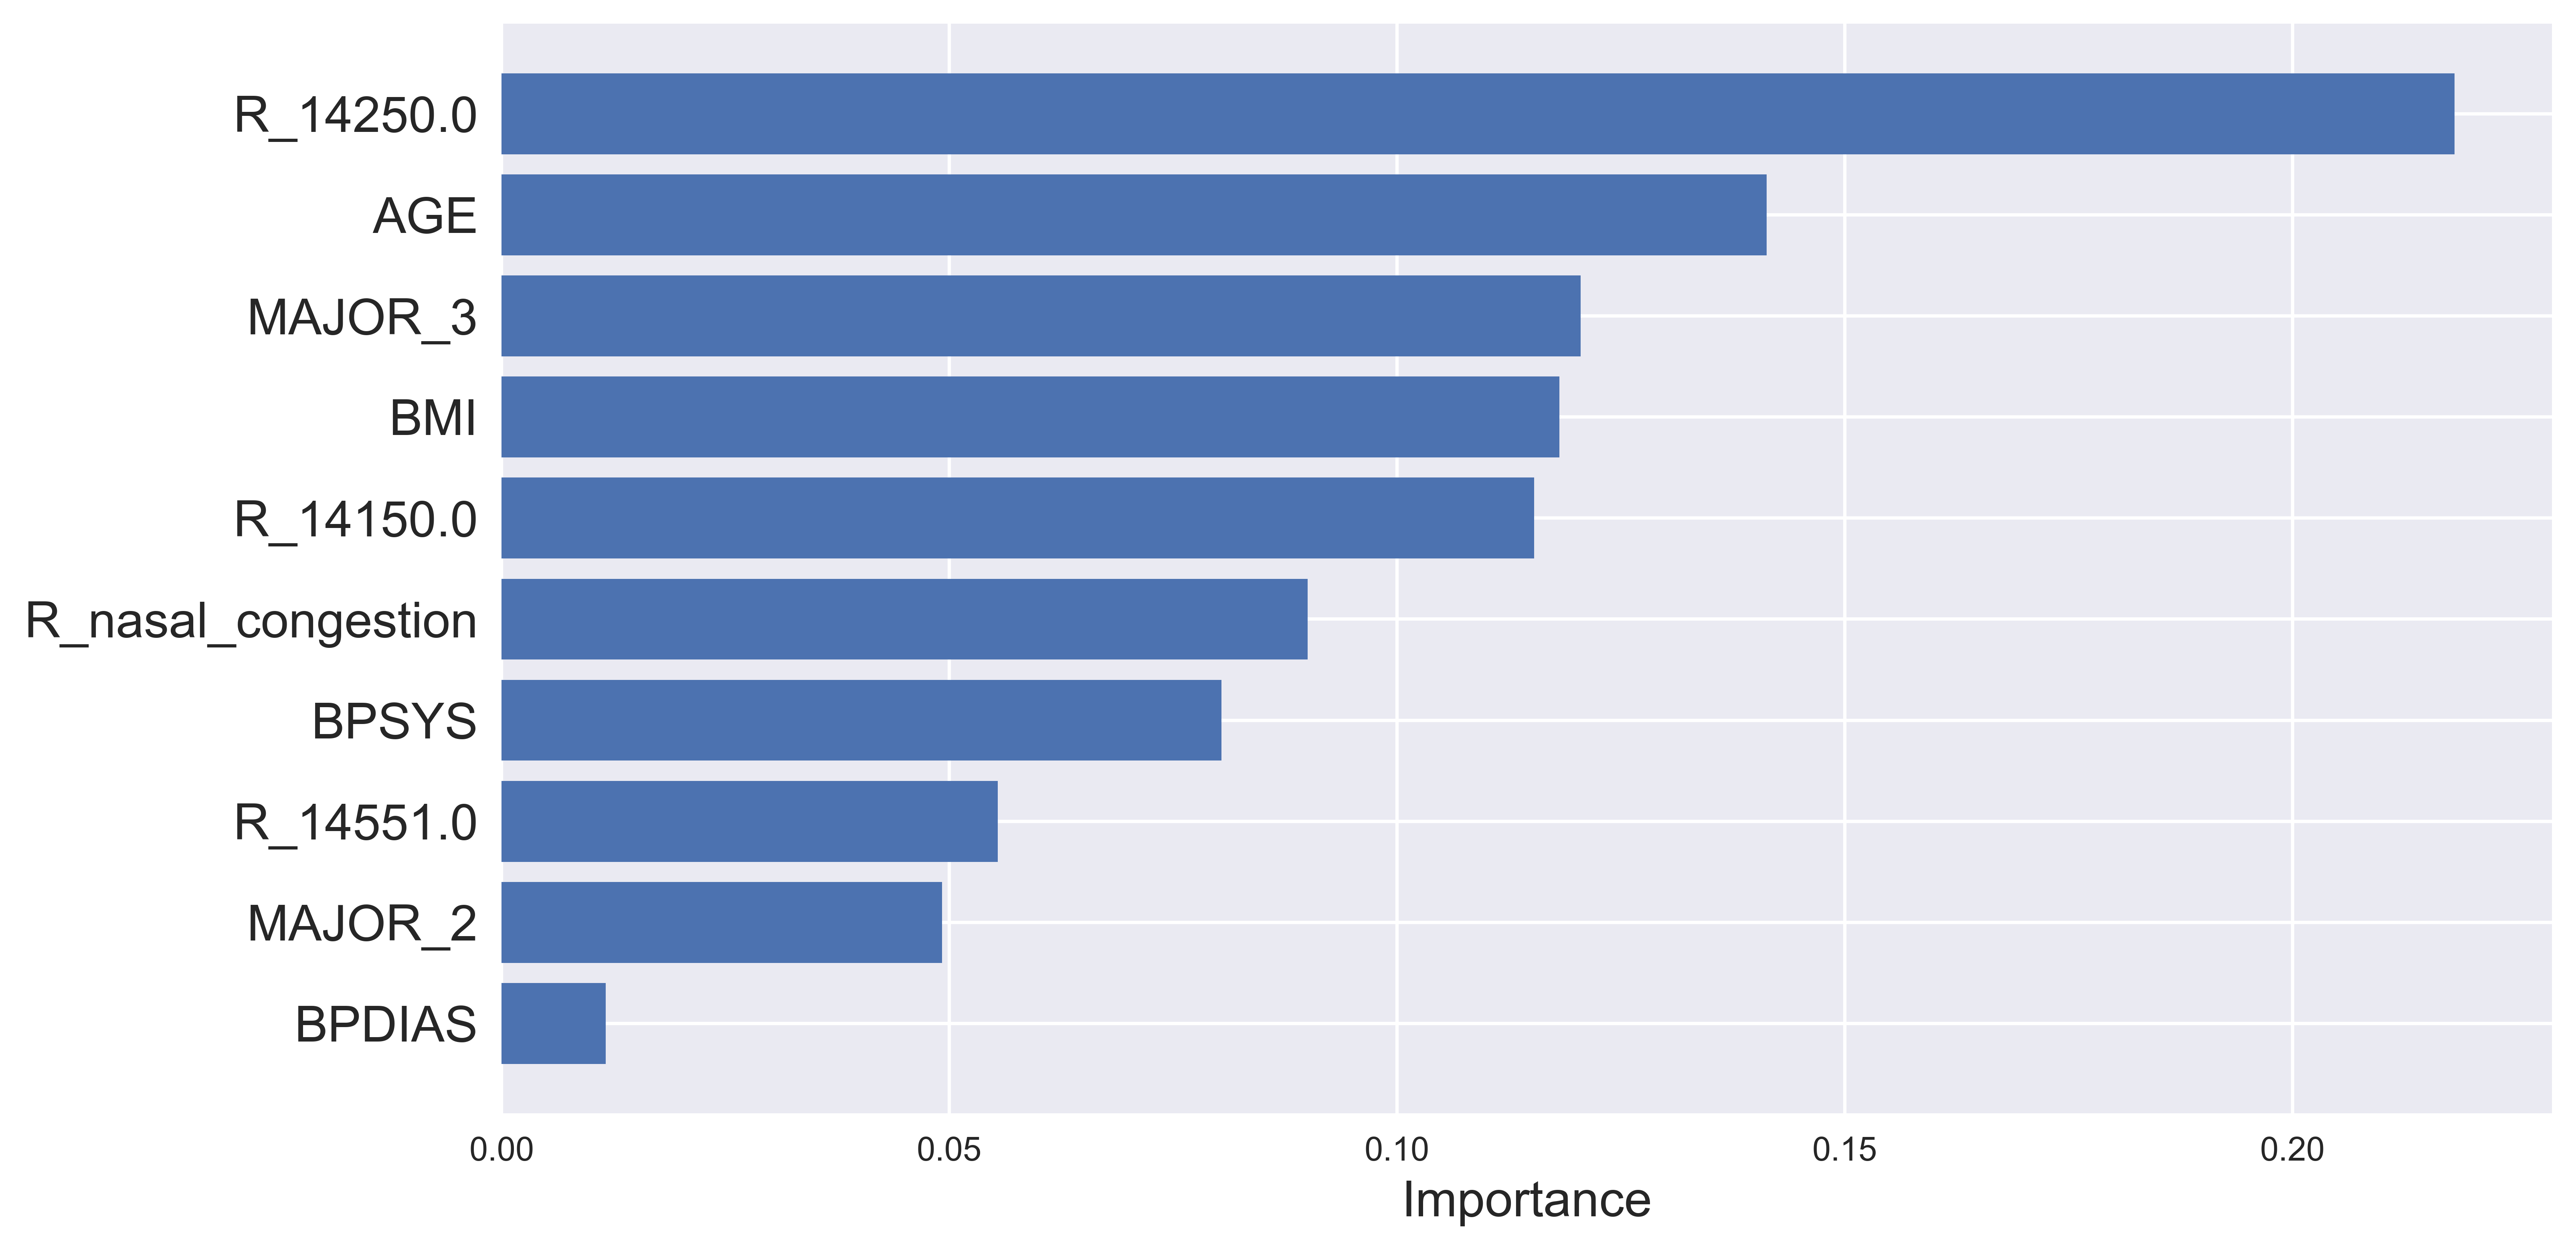

In [410]:
importances = estRF.feature_importances_ # importance of each feature
print(importances)
indices = np.argsort(importances)[::-1]
print(indices)

df_imp_RF = pd.DataFrame({'label':features_selected2,'feature_name':features_selected2,'imp':rf_loaded.feature_importances_})
df_imp_RF_sorted = df_imp_RF.sort_values(by = 'imp',axis = 0, ascending = False)
print(df_imp_RF)
#print(np.std(X_train, 0)*est.coef_)
horizontal_bar_plot (df_imp_RF_sorted.feature_name, df_imp_RF_sorted.imp, 'Importance')

# Plot confusion matrix

In [ ]:
import itertools
class_names = ['mild','severe']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=25)
    plt.yticks(tick_marks, classes, fontsize=25)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j], 2),
                 horizontalalignment='center', fontsize=30,
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label', fontsize=40)
    plt.xlabel('Predicted label', fontsize=40)

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig1 = plt.figure(figsize=(15, 10))
plt.subplot(221)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
fig2 = plt.figure(figsize=(15, 10))
plt.subplot(221)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

fig1.savefig('cnf_matrix_non_norm.png')
fig2.savefig('cnf_matrix_norm.png')

# Plot ROC curve

In [211]:
def plot_ROC(Ytest, Yprobas,model):
    fpr, tpr, thresholds = metrics.roc_curve(Ytest, Yprobas)
    ROCarea = metrics.auc(fpr, tpr)
    print("Area under ROC curve: %.2f" % ROCarea)
    plt.plot(fpr, tpr, label = model)
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False positive rate', fontsize = 15)
    plt.ylabel('True positive rate', fontsize = 15)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('ROC curve', fontsize = 20)
    plt.legend(loc="lower right", fontsize = 15)
    return plt

Area under ROC curve: 0.81
Area under ROC curve: 0.77


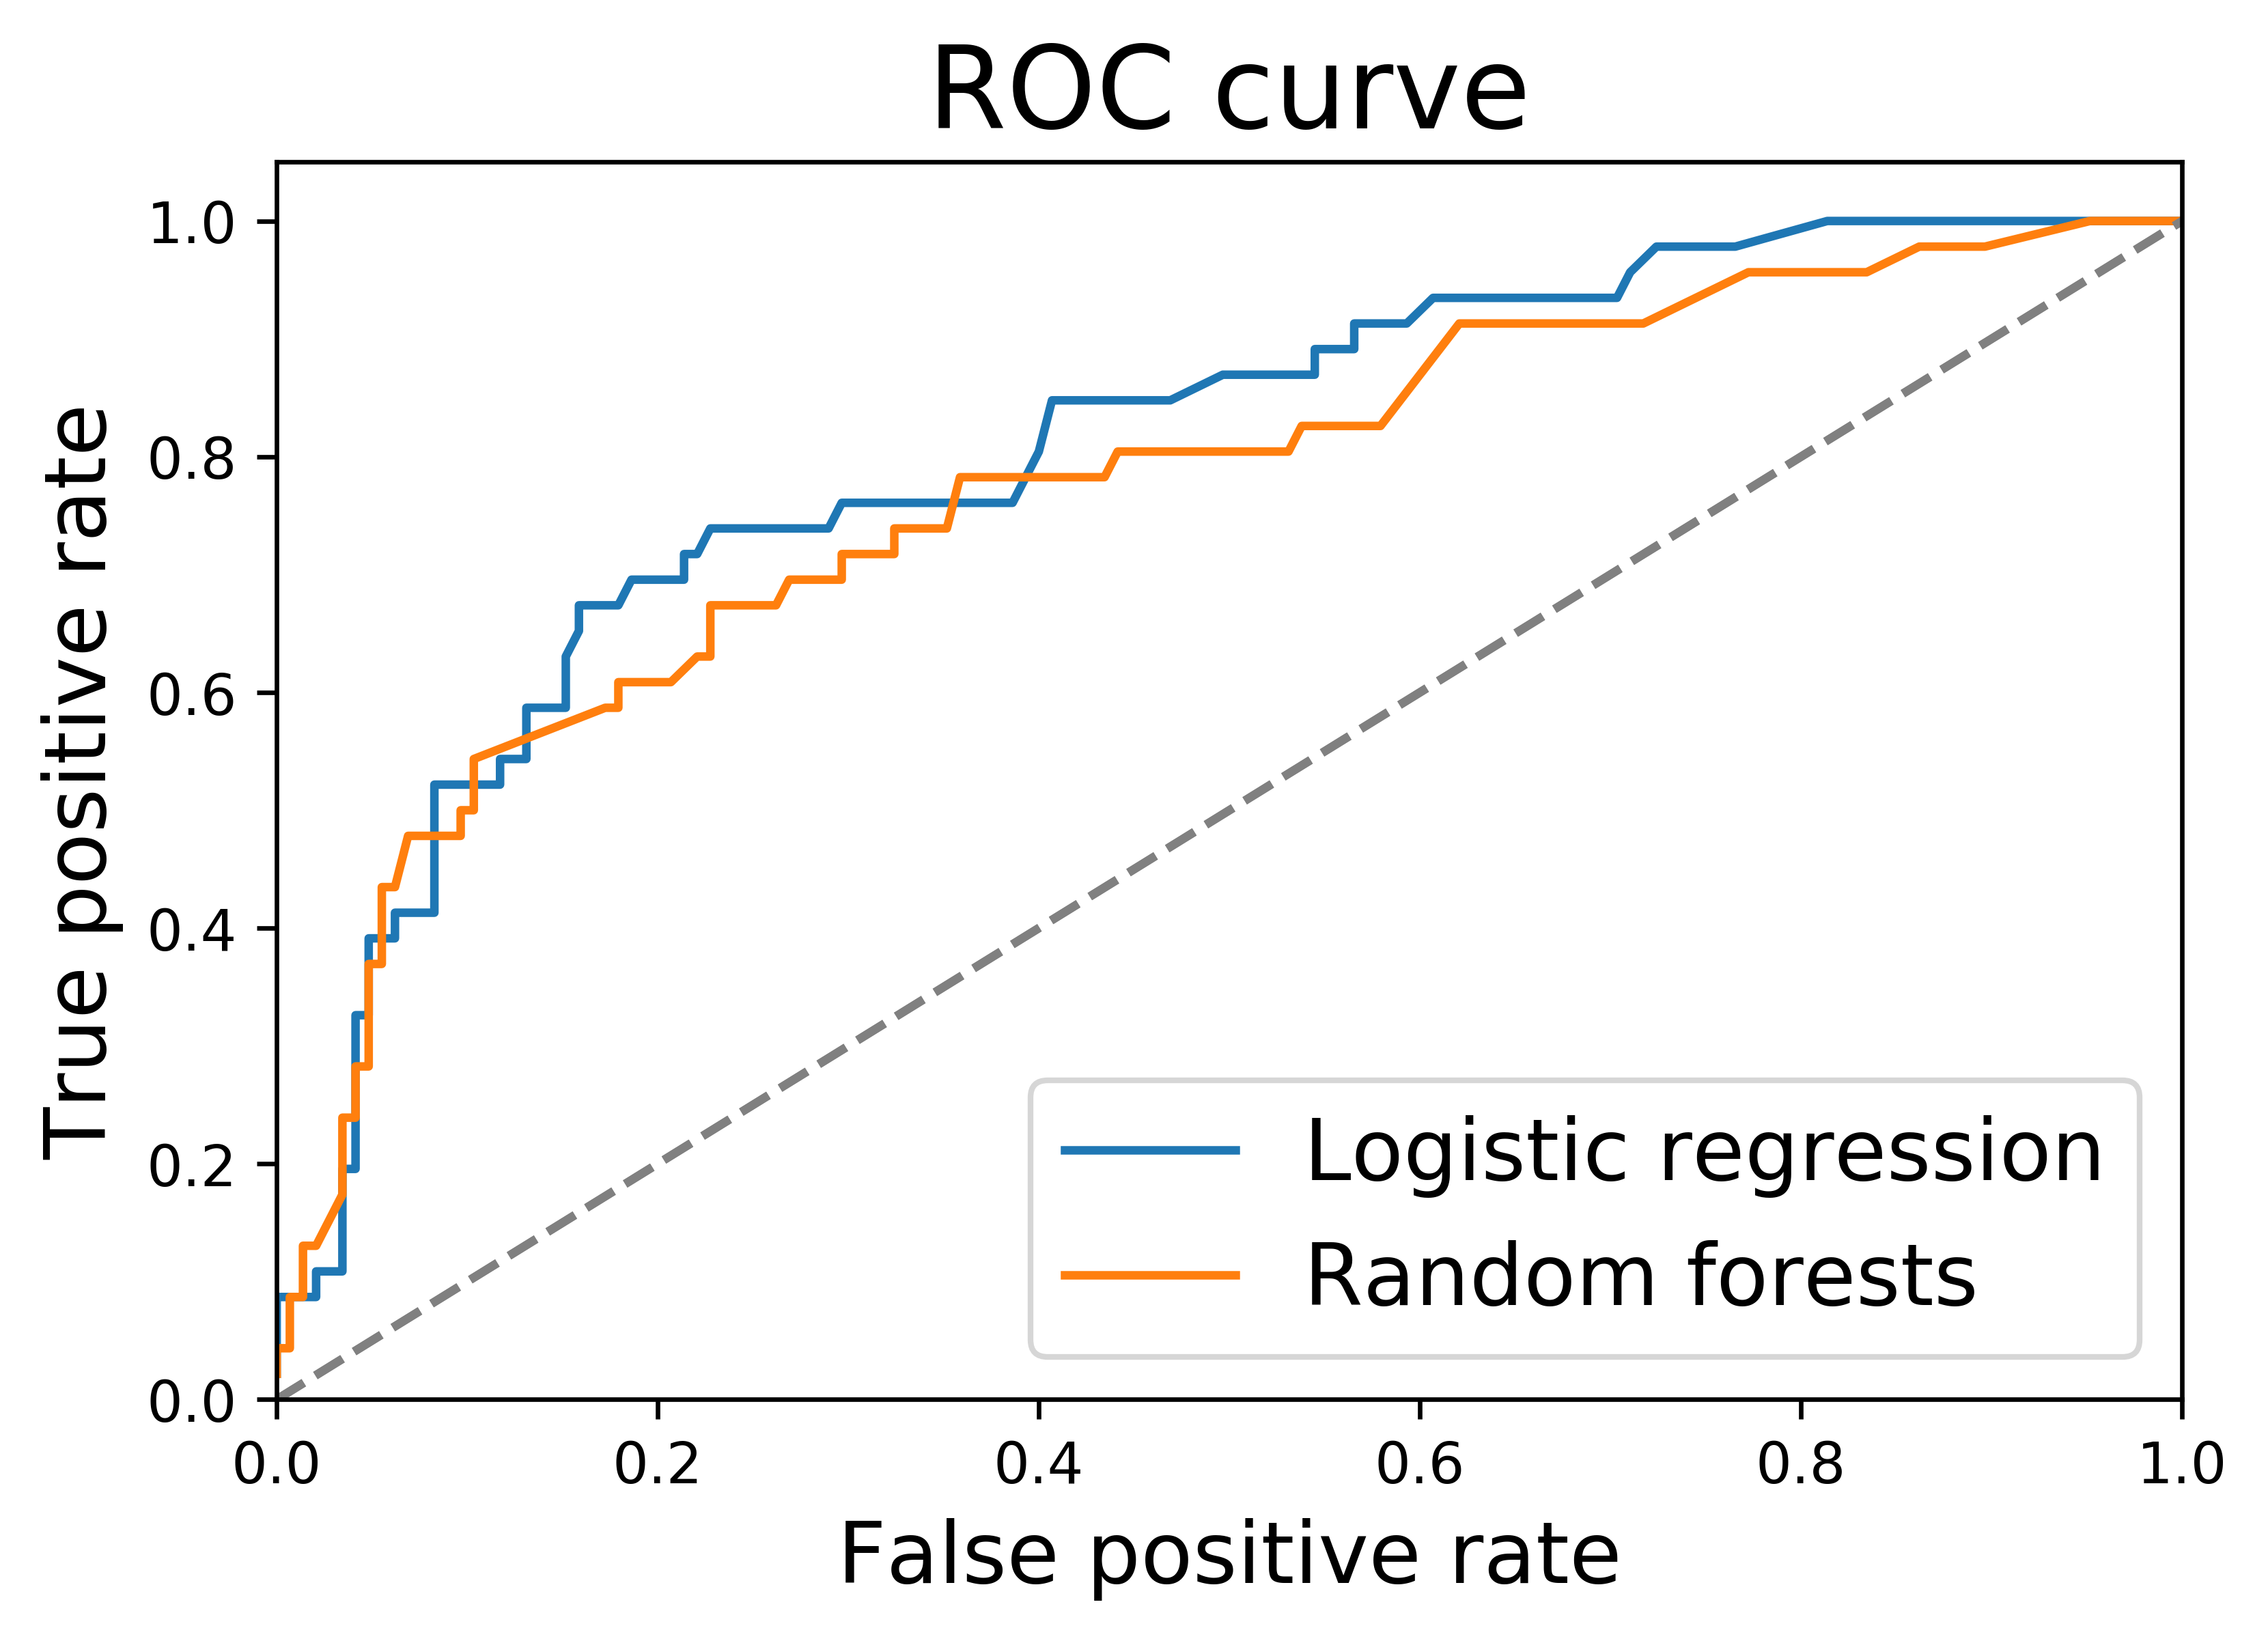

In [212]:
fig, ax = plt.subplots(dpi = 600)
fig = plot_ROC(y_test,probas_[:, 1],'Logistic regression')
fig = plot_ROC(y_test,probas2,'Random forests')
ax.grid(False)
fig.savefig('ROC.png',transparent = True)

# Plot learning curve

In [184]:
def plot_learning_curve(X_train, y_train, model, title):
    train_sizes = np.linspace(0.05, 1.0, 20)
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        model, X_train, y_train, scoring='recall', n_jobs=1,
        train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fig = plt.figure(dpi = 600)
    #plt.grid()
    plt.title('Learning curve ('+ title + ')', fontsize = 18)
    plt.xlabel("Training examples", fontsize = 15)
    plt.ylabel("Recall", fontsize = 15)
    plt.ylim(0, 1.1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", markersize = 4,
             label="Training")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", markersize = 4,
             label="Cross-validation")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize = 15)
    fig.savefig('learning_curve_' + title + '.png',bbox_inches='tight')
    return plt    

<module 'matplotlib.pyplot' from '/Users/yue/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

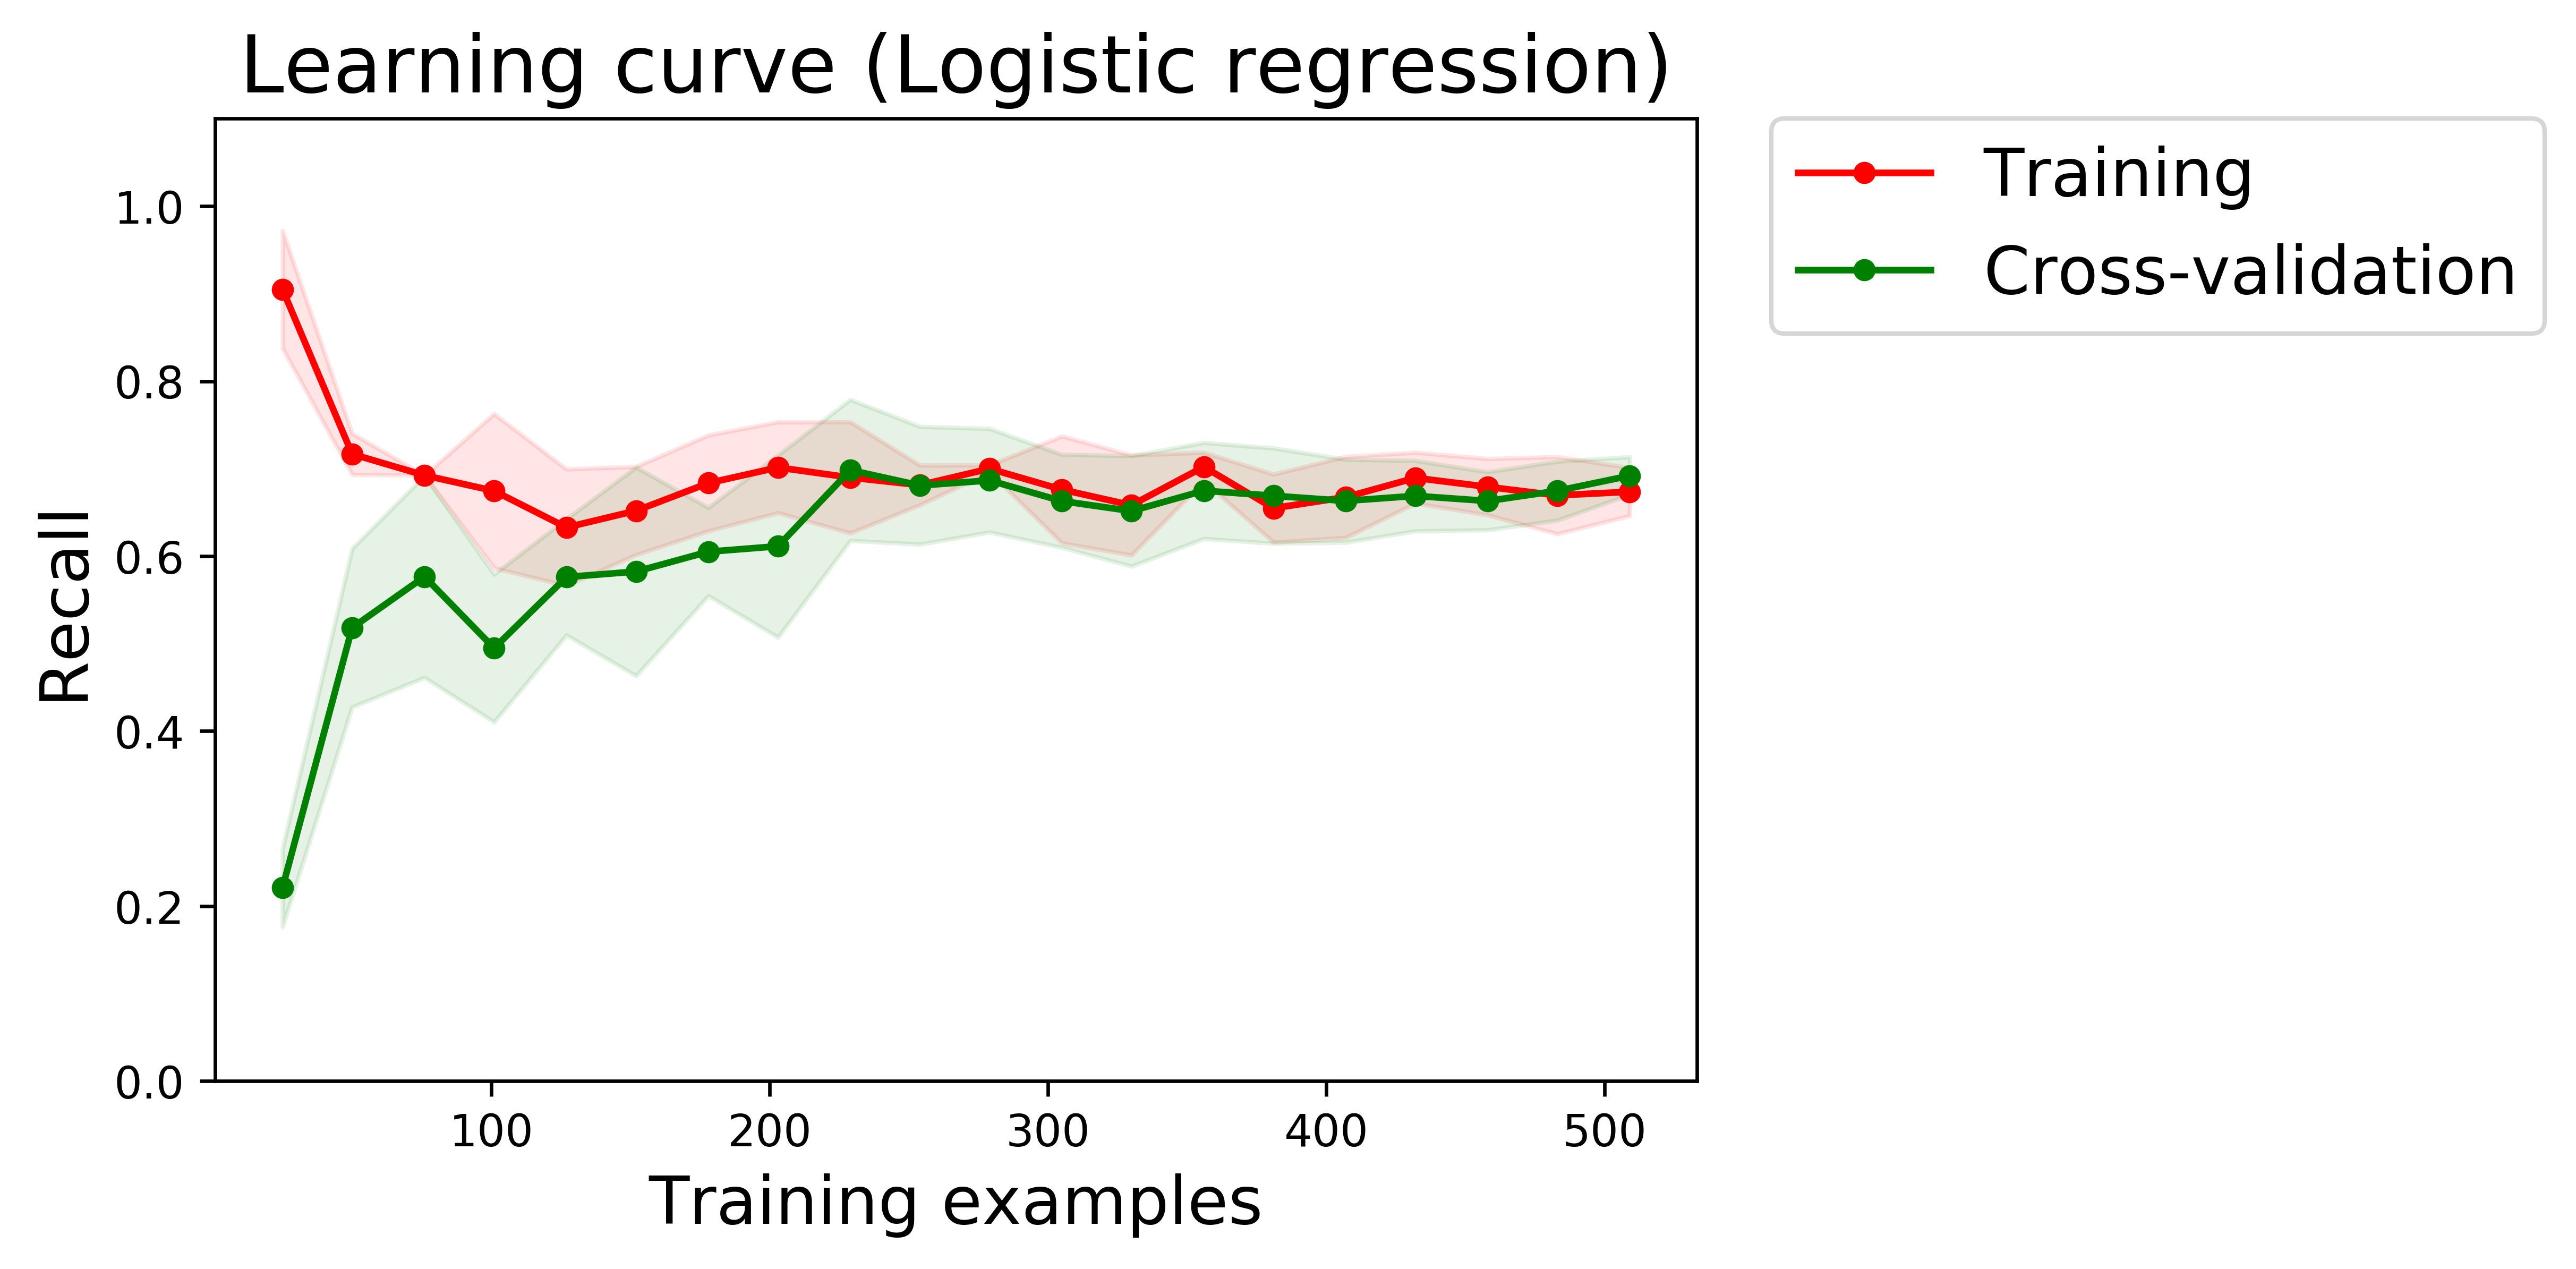

In [186]:
plot_learning_curve (X_train, y_train, LogisticRegression(C = best_C, class_weight='balanced'), 'Logistic regression')

<module 'matplotlib.pyplot' from '/Users/yue/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

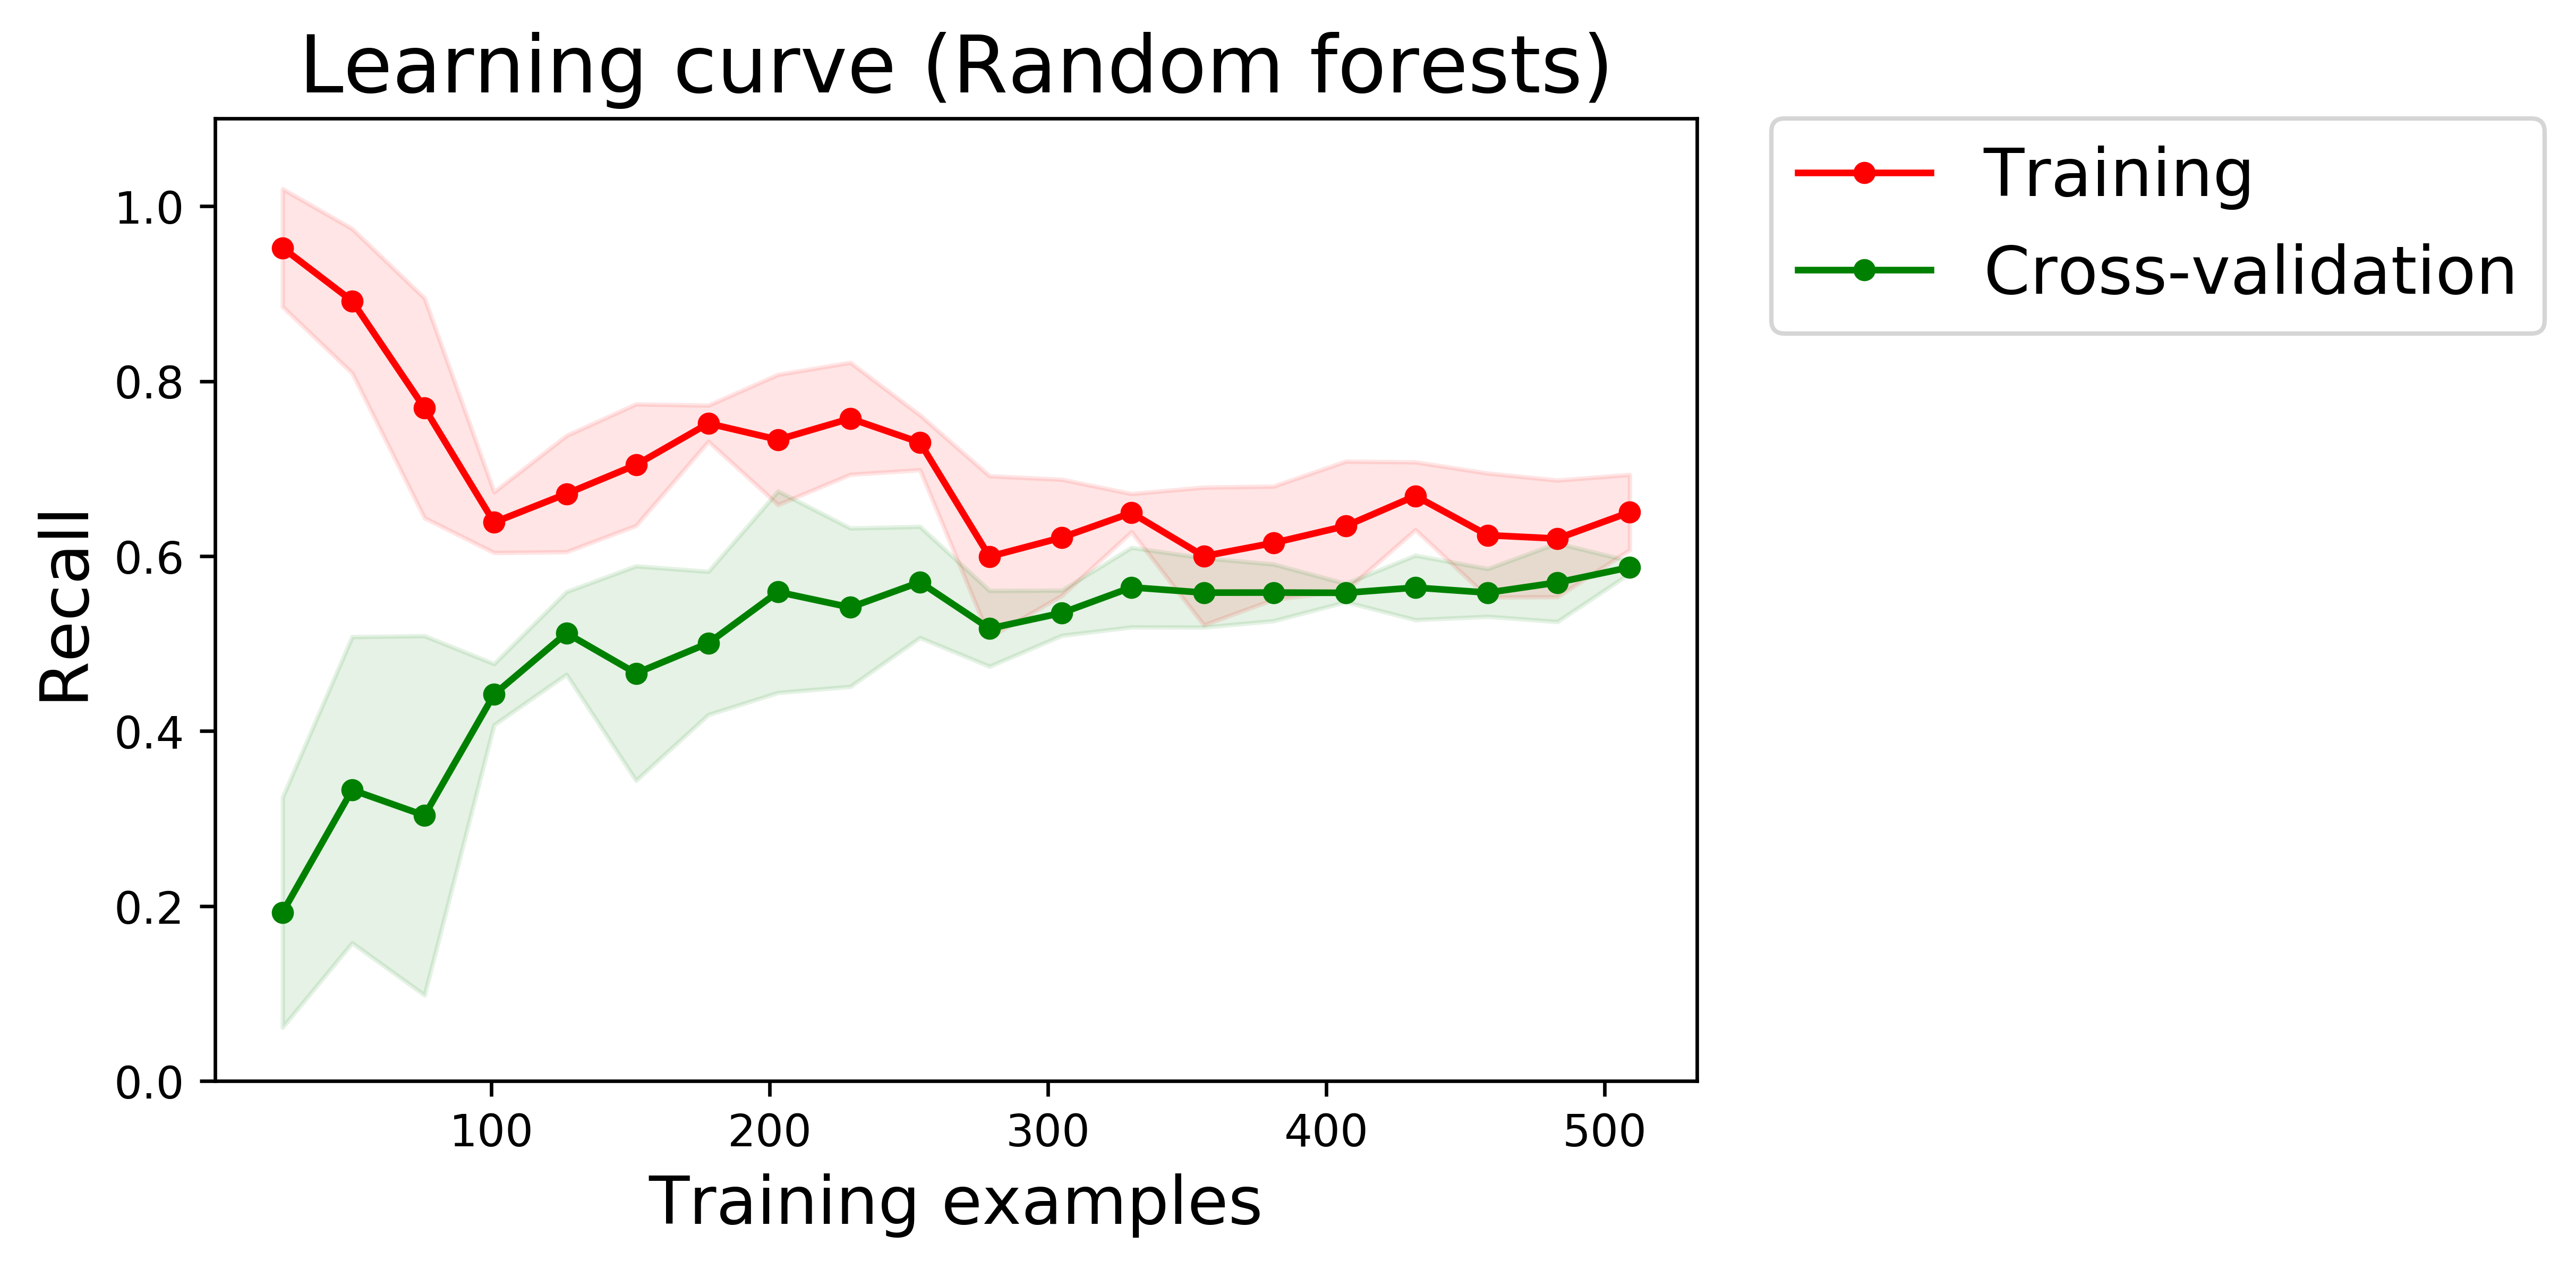

In [185]:
plot_learning_curve (X_train2, y_train, RandomForestClassifier(n_estimators = n_trees, max_depth = n_depth, class_weight = 'balanced'), 'Random forests')

# Plot validation curve

In [417]:
def plot_validation_curve(X_train, y_train, model, model_name, param_name, param_range):
    train_scores, test_scores = model_selection.validation_curve(
        model, X_train, y_train,
        param_name = param_name, param_range = param_range,
        scoring='recall', n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fig = plt.figure(dpi = 600)
    plt.title('Validation Curve (' + model_name + ')', fontsize= 18)
    plt.xlabel(param_name, fontsize = 15)
    plt.ylabel('Recall', fontsize = 15)
    plt.ylim(0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training",
                 marker = 'o', markersize = 4, color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation",
                 marker = 'o', markersize = 4,color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize = 15)
    fig.savefig('Validation_curve_' + model_name + '.png',bbox_inches='tight');

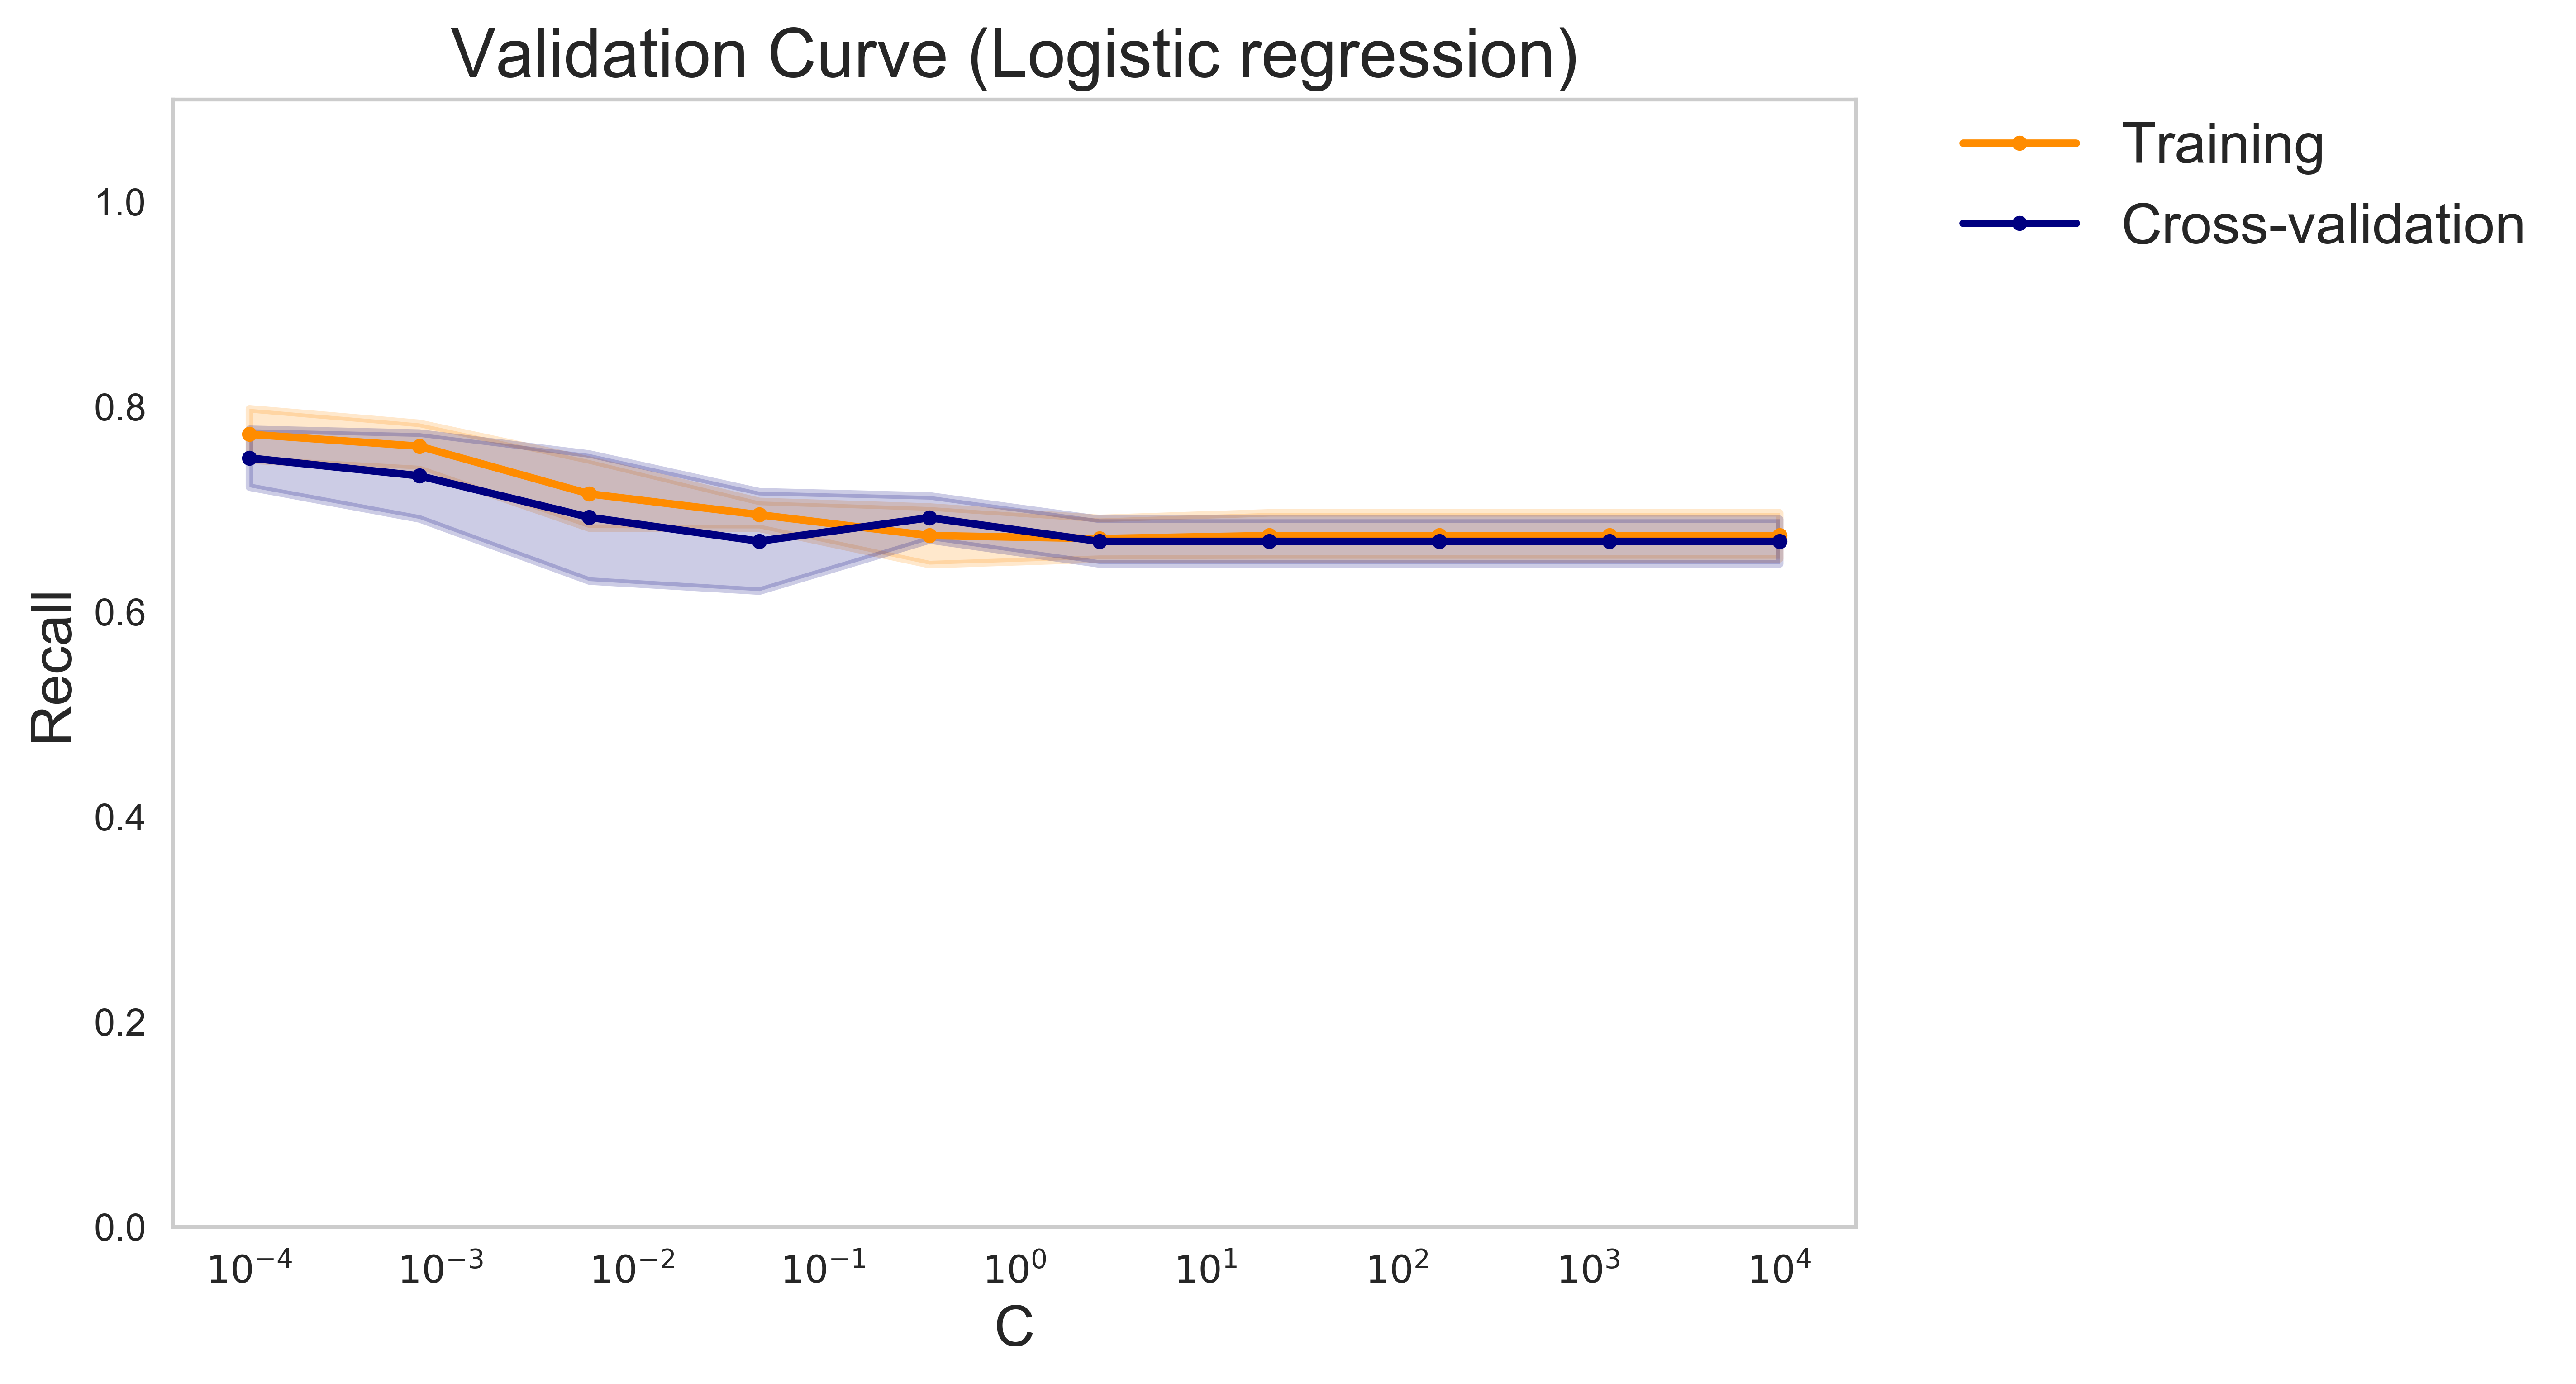

In [418]:
plot_validation_curve(X_train, y_train, LogisticRegression(class_weight='balanced'), 'Logistic regression', 
                      'C', np.logspace(-4, 4, 10))

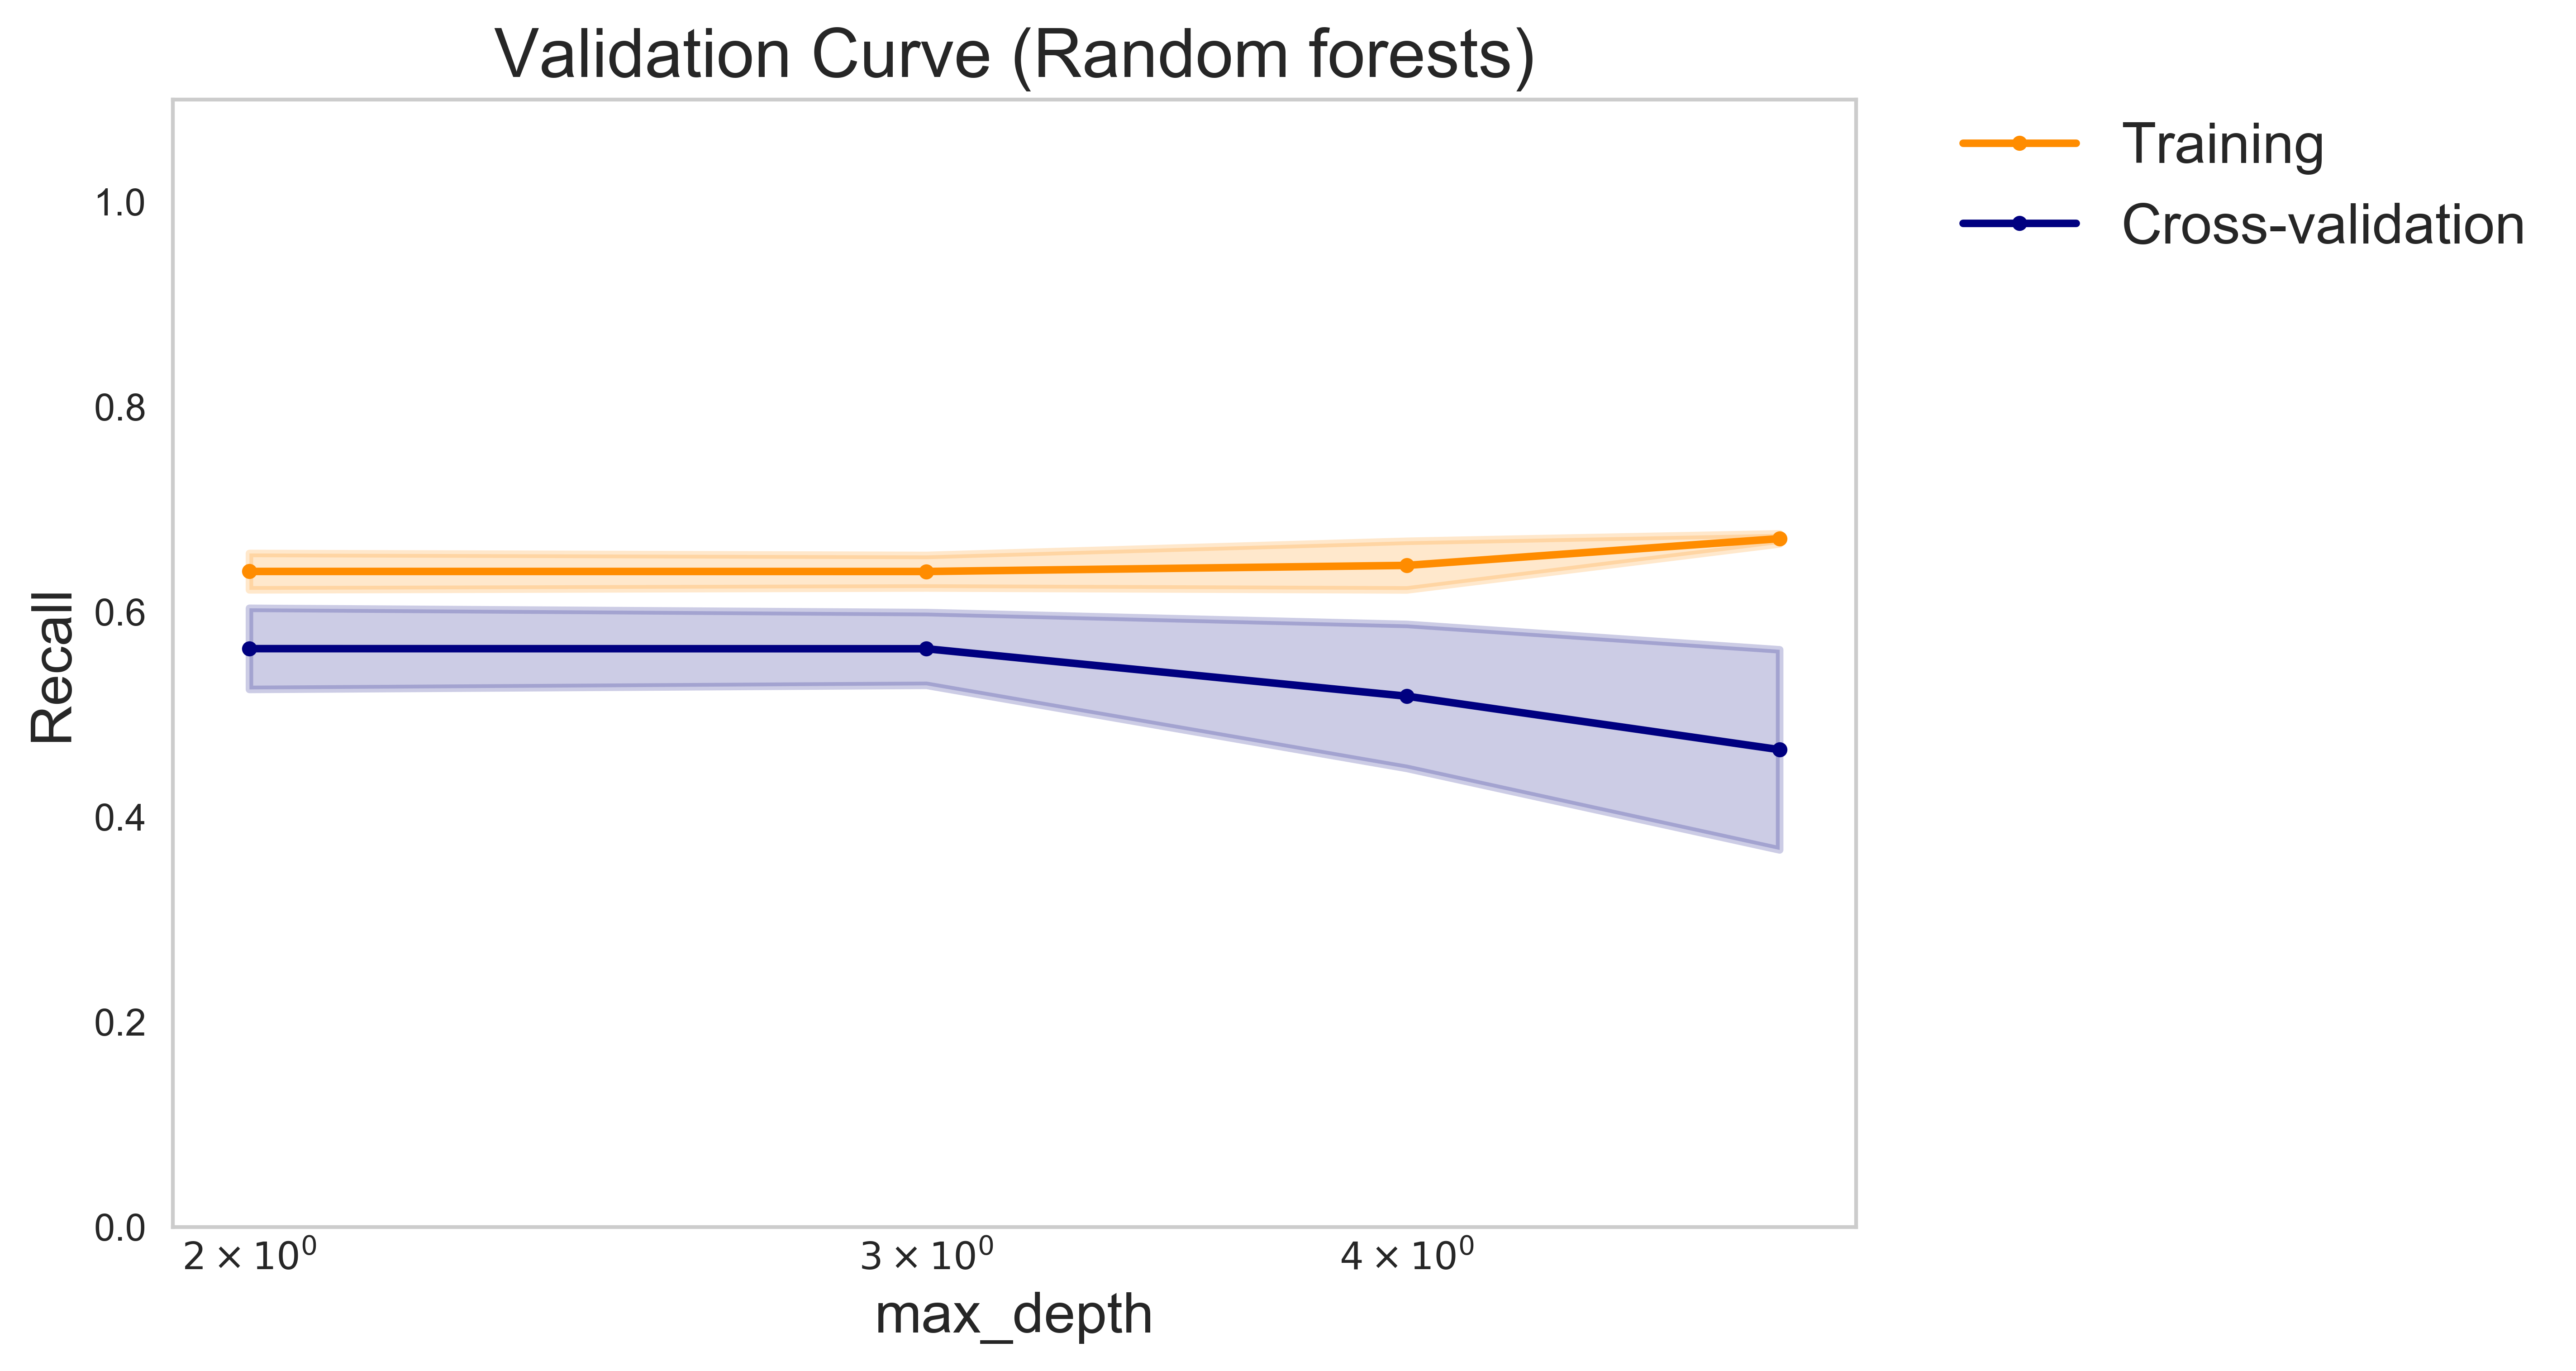

In [419]:
plot_validation_curve (X_train2, y_train, RandomForestClassifier(n_estimators = 45, class_weight = 'balanced'), 'Random forests', 
                       'max_depth', list(range(2,6,1)))